# 采用rnn+lstm的设计实现预测sin()函数功能
## 设计采样序列实现

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 训练数据个数
training_examples = 10000
# 测试数据个数
testing_examples = 1000
# sin函数的采样间隔
sample_gap = 0.01
# 每个训练样本的长度
timesteps = 20

## 生成训练数据和训练标签

In [3]:
def generate_data(seq):#生成训练数据，即训练数据的输入是20个时间步长的时序数据，输出标签是第21个时序时刻的seq数据
    '''
    生成数据，seq是一序列的连续的sin的值
    '''
    X = []
    y = []

    # 用前 timesteps 个sin值，估计第 timesteps+1 个
    # 因此， 输入 X 是一段序列，输出 y 是一个值 
    for i in range(len(seq) - timesteps -1):#生成X是一个二维数组，即20元素的一个序列，N个序列
        X.append(seq[i : i+timesteps])   
        y.append(seq[i+timesteps])    #输出y是一维数组 

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


In [4]:
l=np.linspace(0, 100, 100) 
l

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [5]:
test_start = training_examples*sample_gap#10000*0.01=100
test_end = test_start + testing_examples*sample_gap#100+1000*0.01=110

train_x, train_y = generate_data( np.sin( np.linspace(0, test_start, training_examples) ) ) #即采用10000个生成训练数据
test_x, test_y = generate_data( np.sin( np.linspace(test_start, test_end, testing_examples) ) )
#采用1000个点生成测试数据，并且不能与训练数据重复


In [6]:
print(np.shape(train_x),np.shape(train_y),np.shape(test_x),np.shape(test_y))

(9979, 20) (9979,) (979, 20) (979,)


## 构建rnn网络 

In [7]:
lstm_size = 20#lstm_size代表的是隐藏层中lstm这种cell的size数，可以理解为隐藏单元数，注意lstm_size数和time_step数目的区别，一个是时间维度，一个是隐层lstm单元维度
#可以理解为输入数据维度为64*20*1,20代表时间序列，即时间维度
#lstm_size代表数据维度4，即4个lstm并行处理，即每个1对应的输出是4，则总输出为64*20*4
lstm_layers = 2
batch_size = 64

In [8]:
x = tf.placeholder(tf.float32, [None, timesteps, 1], name='input_x')#dynamic_rnn需要三维的数据输入，即64*20*1，1代表是输入单个时间步长下输入数据维度为1
y_ = tf.placeholder(tf.float32, [None, 1], name='input_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')


### 建立lstm层


In [9]:
# 有lstm_size个单元
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# 添加dropout
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
# 一层不够，就多来几层
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(lstm_size)
cell = tf.contrib.rnn.MultiRNNCell([ lstm_cell() for _ in range(lstm_layers)])

# 进行forward，得到隐层的输出
outputs, final_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
#dynamic_rnn函数实现了执行多步时间，这里的时间步长即输入序列x的长度20， outputs是time_steps步里所有的输出
#tf.nn.dynamic_rnn中输入数据的格式为(batch_size, time_steps, input_size)，其中time_steps表示序列本身的长度，
#最后的input_size就表示输入数据单个序列单个时间维度上固有的长度
#cell代表的是rnn中的cell，这里选择的是lstm，并且lstm的unit_num是由lstm_size设置
# 在本问题中只关注最后一个时刻的输出结果，该结果为下一个时刻的预测值
print(np.shape(outputs))# 64*20*4为隐层输出维度   outputs.shape = [batch_size, timestep_size, hidden_size] 
outputs = outputs[:,-1,:]#即时间维度上取最后一个时间步长的数据
print(np.shape(outputs)) #64*4为最后一个时刻的输出  ， h_state = outputs[:, -1, :] 作为最后输出， 最后输出维度是 [batch_size, hidden_size]
#得到的outputs就是time_steps步里所有的输出。它的形状为(batch_size, time_steps, cell.output_size)。即64*20*1
#state是最后一步的隐状态，它的形状为(batch_size, cell.state_size)。
# 定义输出层, 输出值[-1,1]，因此激活函数用tanh
predictions = tf.contrib.layers.fully_connected(outputs, 1, activation_fn=tf.tanh)#采用全连接层
# 定义损失函数
cost = tf.losses.mean_squared_error(y_, predictions)
# 定义优化步骤
optimizer = tf.train.AdamOptimizer().minimize(cost)


Instructions for updating:
Use the retry module or similar alternatives.
(?, 20, 20)
(?, 20)


## 设计一个迭代器 实现batch功能

In [10]:
# 获取一个batch_size大小的数据  ,每次batch为64组数据
def get_batches(X, y, batch_size=64):
    for i in range(0, len(X), batch_size):
        begin_i = i
        end_i = i + batch_size if (i+batch_size) < len(X) else len(X)

        yield X[begin_i:end_i,:], y[begin_i:end_i]


In [11]:
batch=get_batches(train_x,train_y)
batch_x,batch_y=next(batch)
print(np.shape(batch_x),np.shape(batch_y))

(64, 20) (64,)


### seq是一个一维的10000的数组，train_x是一个10000*20的二维数组，batch_x是一个64*20的二维数组，为每次输入数据，

In [12]:
epochs = 20
session = tf.Session()
with session.as_default() as sess:
    # 初始化变量
    tf.global_variables_initializer().run()

    iteration = 1

    for e in range(epochs):
        for xs, ys in get_batches(train_x, train_y, batch_size):#相当于next（batch） ，迭代器
            # xs[:,:,None] 增加一个维度，例如[64, 20] ==> [64, 20, 1]，为了对应输入
            # 同理 ys[:,None]
            feed_dict = { x:xs[:,:,None], y_:ys[:,None], keep_prob:.5 }#这里的x是64*20，在占位符中定义的是64*20*1

            loss, _ = sess.run([cost, optimizer], feed_dict=feed_dict)

            if iteration % 100 == 0:
                print('Epochs:{}/{}'.format(e, epochs),
                      'Iteration:{}'.format(iteration),
                      'Train loss: {:.8f}'.format(loss))
            iteration += 1


Epochs:0/20 Iteration:100 Train loss: 0.01217230
Epochs:1/20 Iteration:200 Train loss: 0.01994674
Epochs:1/20 Iteration:300 Train loss: 0.00327074
Epochs:2/20 Iteration:400 Train loss: 0.00536955
Epochs:3/20 Iteration:500 Train loss: 0.00418423
Epochs:3/20 Iteration:600 Train loss: 0.00195003
Epochs:4/20 Iteration:700 Train loss: 0.00278126
Epochs:5/20 Iteration:800 Train loss: 0.00024602
Epochs:5/20 Iteration:900 Train loss: 0.00175645
Epochs:6/20 Iteration:1000 Train loss: 0.00027043
Epochs:7/20 Iteration:1100 Train loss: 0.00212086
Epochs:7/20 Iteration:1200 Train loss: 0.00023190
Epochs:8/20 Iteration:1300 Train loss: 0.00091446
Epochs:8/20 Iteration:1400 Train loss: 0.00007543
Epochs:9/20 Iteration:1500 Train loss: 0.00230176
Epochs:10/20 Iteration:1600 Train loss: 0.00038034
Epochs:10/20 Iteration:1700 Train loss: 0.00154190
Epochs:11/20 Iteration:1800 Train loss: 0.00027213
Epochs:12/20 Iteration:1900 Train loss: 0.00141279
Epochs:12/20 Iteration:2000 Train loss: 0.00006687
Epoc

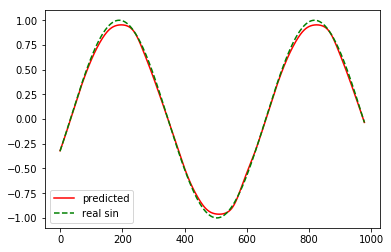

In [13]:
with session.as_default() as sess:
    ## 测试结果
    feed_dict = {x:test_x[:,:,None], keep_prob:1.0}
    results = sess.run(predictions, feed_dict=feed_dict)
    plt.plot(results,'r', label='predicted')
    plt.plot(test_y, 'g--', label='real sin')
    plt.legend()
    plt.show()
